In [1]:
import os

%matplotlib inline
import string
import sys
import seaborn as sn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

%matplotlib inline
import string
import sys
from collections import deque

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import statistics

sys.path.append("code/.")
from sklearn import datasets
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import average_precision_score
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import StackingClassifier
import eli5

# Fantasy Baseball 2023 Projections
### Matthew Gillies

In this exploration I will use metrics and advanced statistics in order to predict the fantasy statistics of MLB players in the 2023 season. I have utilized multiple dataset from baseball savant (https://baseballsavant.mlb.com) in order to complete this analysis. The primary data was constructed by taking metrics and advanced statistics from 2018-2021 and per game fantasy scores from 2019-2022 for qualified batters. The "year" column represents the year that the fantasy average occurred, and the metrics in each row are representative of the year prior to what the data indicates. This is done in order to utilize metrics and statistics from 2022 in order to predict fantasy points in 2023. Once the model is complete and is able to effectively predict the fantasy score per game, I will apply predictions for number of games played in 2023 to compute an entire season prediction. Games played in 2023 will simply be calculated as the average games played per season from 2018-2022 (with the 2020 season normalized to a 162 game season. Team factors will also be applied to account for the differentiating results in different ballparks. A similar analysis will also be performed for pitchers (starting and relief), and the results will be combined to create overall rankings. 

##### Note: These rankings should not be used exactly to draft, as they are heavily based on metrics and quite biased towards certain skillsets. I would recommend using these rankings as a basis for players you should draft above/below ADP. 

In [2]:
## Reading in data
os.chdir("/Users/matthewgillies/FantasyPreds2023")
data = pd.read_csv("data/full_data.csv", index_col = 0)
data.head()

,year,player_age,xslg,xwoba,xobp,exit_velocity_avg,launch_angle_avg,sweet_spot_percent,barrel_batted_rate,solidcontact_percent,hard_hit_percent,z_swing_percent,oz_swing_percent,groundballs_percent,flyballs_percent,linedrives_percent,popups_percent,sprint_speed,fpoints_g
player,,,,,,,,,,,,,,,,,,,
"Cruz Jr., Nelson",2022,40.0,0.512,0.363,0.341,92.9,11.8,31.8,13.6,8.1,52.5,73.8,31.0,43.4,25.5,22.0,9.1,26.0,1.604839
"Blackmon, Charlie",2022,34.0,0.450,0.359,0.369,87.6,10.2,32.6,7.0,3.5,38.5,67.9,26.2,47.4,22.3,24.4,5.9,27.7,2.125926
"McCutchen, Andrew",2022,34.0,0.431,0.344,0.352,88.8,14.6,33.6,9.0,8.4,39.5,63.7,19.1,40.9,30.5,21.6,7.0,28.7,2.044776
"Turner, Justin",2022,36.0,0.470,0.359,0.358,90.9,19.2,36.5,7.9,8.6,42.4,66.9,22.7,35.4,33.1,24.5,7.0,25.5,2.429688
"Andrus, Elvis",2022,32.0,0.375,0.308,0.324,87.8,8.1,34.0,2.1,5.9,34.8,65.9,31.9,47.0,17.5,28.4,7.1,26.7,2.046980


In [3]:
## Checking for NA Values
data.isna().any()

year                    False
player_age               True
xslg                     True
xwoba                    True
xobp                     True
exit_velocity_avg        True
launch_angle_avg         True
sweet_spot_percent       True
barrel_batted_rate       True
solidcontact_percent     True
hard_hit_percent         True
z_swing_percent          True
oz_swing_percent         True
groundballs_percent      True
flyballs_percent         True
linedrives_percent       True
popups_percent           True
sprint_speed             True
fpoints_g               False
dtype: bool

In [4]:
## Visualizing rows with NA values. It is hypothesized that NA values come from players who retired throughout this 
## stretch or who just began playing. 
data[data['player_age'].isna()]

,year,player_age,xslg,xwoba,xobp,exit_velocity_avg,launch_angle_avg,sweet_spot_percent,barrel_batted_rate,solidcontact_percent,hard_hit_percent,z_swing_percent,oz_swing_percent,groundballs_percent,flyballs_percent,linedrives_percent,popups_percent,sprint_speed,fpoints_g
player,,,,,,,,,,,,,,,,,,,
"Devers, Rafael",2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.461538
"Tatis Jr., Fernando",2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.389831
"Soto, Juan",2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.366667
"Acuna Jr., Ronald",2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.057692
"Yastrzemski, Mike",2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.962963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Gonzalez, Marwin",2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.301887
"Gallo, Joey",2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.298246
"Gonzalez, Erik",2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.160000


This suspicion is confirmed, as the data with NA's comes from the year before a player reached the MLB or the year after retirement. NA values can simply be dropped. 

In [5]:
## Dropping NA rows
data = data.dropna()

In [6]:
data.isna().any()

year                    False
player_age              False
xslg                    False
xwoba                   False
xobp                    False
exit_velocity_avg       False
launch_angle_avg        False
sweet_spot_percent      False
barrel_batted_rate      False
solidcontact_percent    False
hard_hit_percent        False
z_swing_percent         False
oz_swing_percent        False
groundballs_percent     False
flyballs_percent        False
linedrives_percent      False
popups_percent          False
sprint_speed            False
fpoints_g               False
dtype: bool

In [7]:
data.shape

(337, 19)

In [8]:
## Removing the year column as the model should not take the year into account for future predictions
data = data.drop(columns = 'year')

In [9]:
## Data splitting with 70/30 split
X = data.drop(columns = "fpoints_g")
y = data["fpoints_g"]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 123)
X_train.head()

,player_age,xslg,xwoba,xobp,exit_velocity_avg,launch_angle_avg,sweet_spot_percent,barrel_batted_rate,solidcontact_percent,hard_hit_percent,z_swing_percent,oz_swing_percent,groundballs_percent,flyballs_percent,linedrives_percent,popups_percent,sprint_speed
player,,,,,,,,,,,,,,,,,
"Polanco, Jorge",26.0,0.381,0.304,0.308,86.6,16.1,39.0,2.8,5.1,33.3,64.4,23.2,37.3,27.7,27.1,7.9,27.8
"Altuve, Jose",28.0,0.449,0.352,0.360,87.2,10.1,34.0,5.9,5.2,33.8,68.0,30.2,48.1,22.4,25.5,3.9,28.1
"Rojas, Josh",27.0,0.357,0.299,0.318,88.2,8.4,40.7,4.8,4.6,31.1,62.9,21.2,49.6,20.8,27.6,2.0,27.6
"Brantley Jr., Michael",31.0,0.452,0.357,0.365,90.2,9.5,38.3,3.5,6.0,38.4,65.2,23.7,46.2,18.0,31.1,4.6,26.0
"Tapia, Raimel",26.0,0.325,0.285,0.305,85.3,1.8,28.7,2.0,2.7,30.0,71.3,30.7,56.0,17.3,24.0,2.7,28.2


In [10]:
## Further inspecting the data
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 269 entries, Polanco, Jorge to Moncada, Yoan
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   player_age            269 non-null    float64
 1   xslg                  269 non-null    float64
 2   xwoba                 269 non-null    float64
 3   xobp                  269 non-null    float64
 4   exit_velocity_avg     269 non-null    float64
 5   launch_angle_avg      269 non-null    float64
 6   sweet_spot_percent    269 non-null    float64
 7   barrel_batted_rate    269 non-null    float64
 8   solidcontact_percent  269 non-null    float64
 9   hard_hit_percent      269 non-null    float64
 10  z_swing_percent       269 non-null    float64
 11  oz_swing_percent      269 non-null    float64
 12  groundballs_percent   269 non-null    float64
 13  flyballs_percent      269 non-null    float64
 14  linedrives_percent    269 non-null    float64
 15  popup

In [11]:
X_train.describe()

,player_age,xslg,xwoba,xobp,exit_velocity_avg,launch_angle_avg,sweet_spot_percent,barrel_batted_rate,solidcontact_percent,hard_hit_percent,z_swing_percent,oz_swing_percent,groundballs_percent,flyballs_percent,linedrives_percent,popups_percent,sprint_speed
count,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000
mean,27.962825,0.456297,0.343141,0.340275,89.539777,12.727138,34.283643,8.728625,6.415613,40.358364,68.163569,27.491450,43.099628,24.997770,25.101487,6.795911,27.300372
std,3.531113,0.068973,0.035656,0.034116,2.079865,4.397350,3.962948,3.932371,1.727536,6.753930,5.430697,5.890959,6.398481,4.988202,3.281586,2.779392,1.239508
min,20.000000,0.287000,0.261000,0.256000,83.300000,-1.500000,18.700000,0.900000,2.700000,23.000000,56.000000,12.200000,29.800000,11.500000,16.600000,1.000000,23.100000
25%,25.000000,0.404000,0.318000,0.316000,88.100000,9.900000,31.400000,5.900000,5.200000,35.700000,64.500000,23.500000,38.800000,21.400000,22.900000,4.900000,26.500000
50%,27.000000,0.453000,0.340000,0.336000,89.500000,13.000000,34.500000,8.500000,6.300000,40.500000,67.900000,27.300000,42.600000,24.900000,25.200000,6.600000,27.400000
75%,30.000000,0.498000,0.364000,0.362000,90.900000,15.500000,36.800000,11.400000,7.600000,44.700000,72.200000,30.900000,47.200000,28.200000,27.300000,8.400000,28.200000
max,40.000000,0.696000,0.475000,0.475000,95.800000,26.800000,49.200000,22.900000,11.600000,58.400000,84.100000,46.900000,61.700000,39.400000,34.300000,17.500000,30.700000


In [12]:
## Analyzing correlations of features
corr_matrix = X_train.corr()
plt.figure(figsize = (100,100))
plt.rcParams.update({'font.size': 50})
sn.heatmap(corr_matrix, annot = True)

<AxesSubplot: >

There are strong positive and negative correlations present within the data. This is to be expected, as many of the statistics are strongly related to each other (xwoba and xslg), while others have an extreme negative relation (flyball % and groundball %). 

array([[<AxesSubplot: title={'center': 'player_age'}>,
        <AxesSubplot: title={'center': 'xslg'}>,
        <AxesSubplot: title={'center': 'xwoba'}>,
        <AxesSubplot: title={'center': 'xobp'}>],
       [<AxesSubplot: title={'center': 'exit_velocity_avg'}>,
        <AxesSubplot: title={'center': 'launch_angle_avg'}>,
        <AxesSubplot: title={'center': 'sweet_spot_percent'}>,
        <AxesSubplot: title={'center': 'barrel_batted_rate'}>],
       [<AxesSubplot: title={'center': 'solidcontact_percent'}>,
        <AxesSubplot: title={'center': 'hard_hit_percent'}>,
        <AxesSubplot: title={'center': 'z_swing_percent'}>,
        <AxesSubplot: title={'center': 'oz_swing_percent'}>],
       [<AxesSubplot: title={'center': 'groundballs_percent'}>,
        <AxesSubplot: title={'center': 'flyballs_percent'}>,
        <AxesSubplot: title={'center': 'linedrives_percent'}>,
        <AxesSubplot: title={'center': 'popups_percent'}>],
       [<AxesSubplot: title={'center': 'sprint_spe

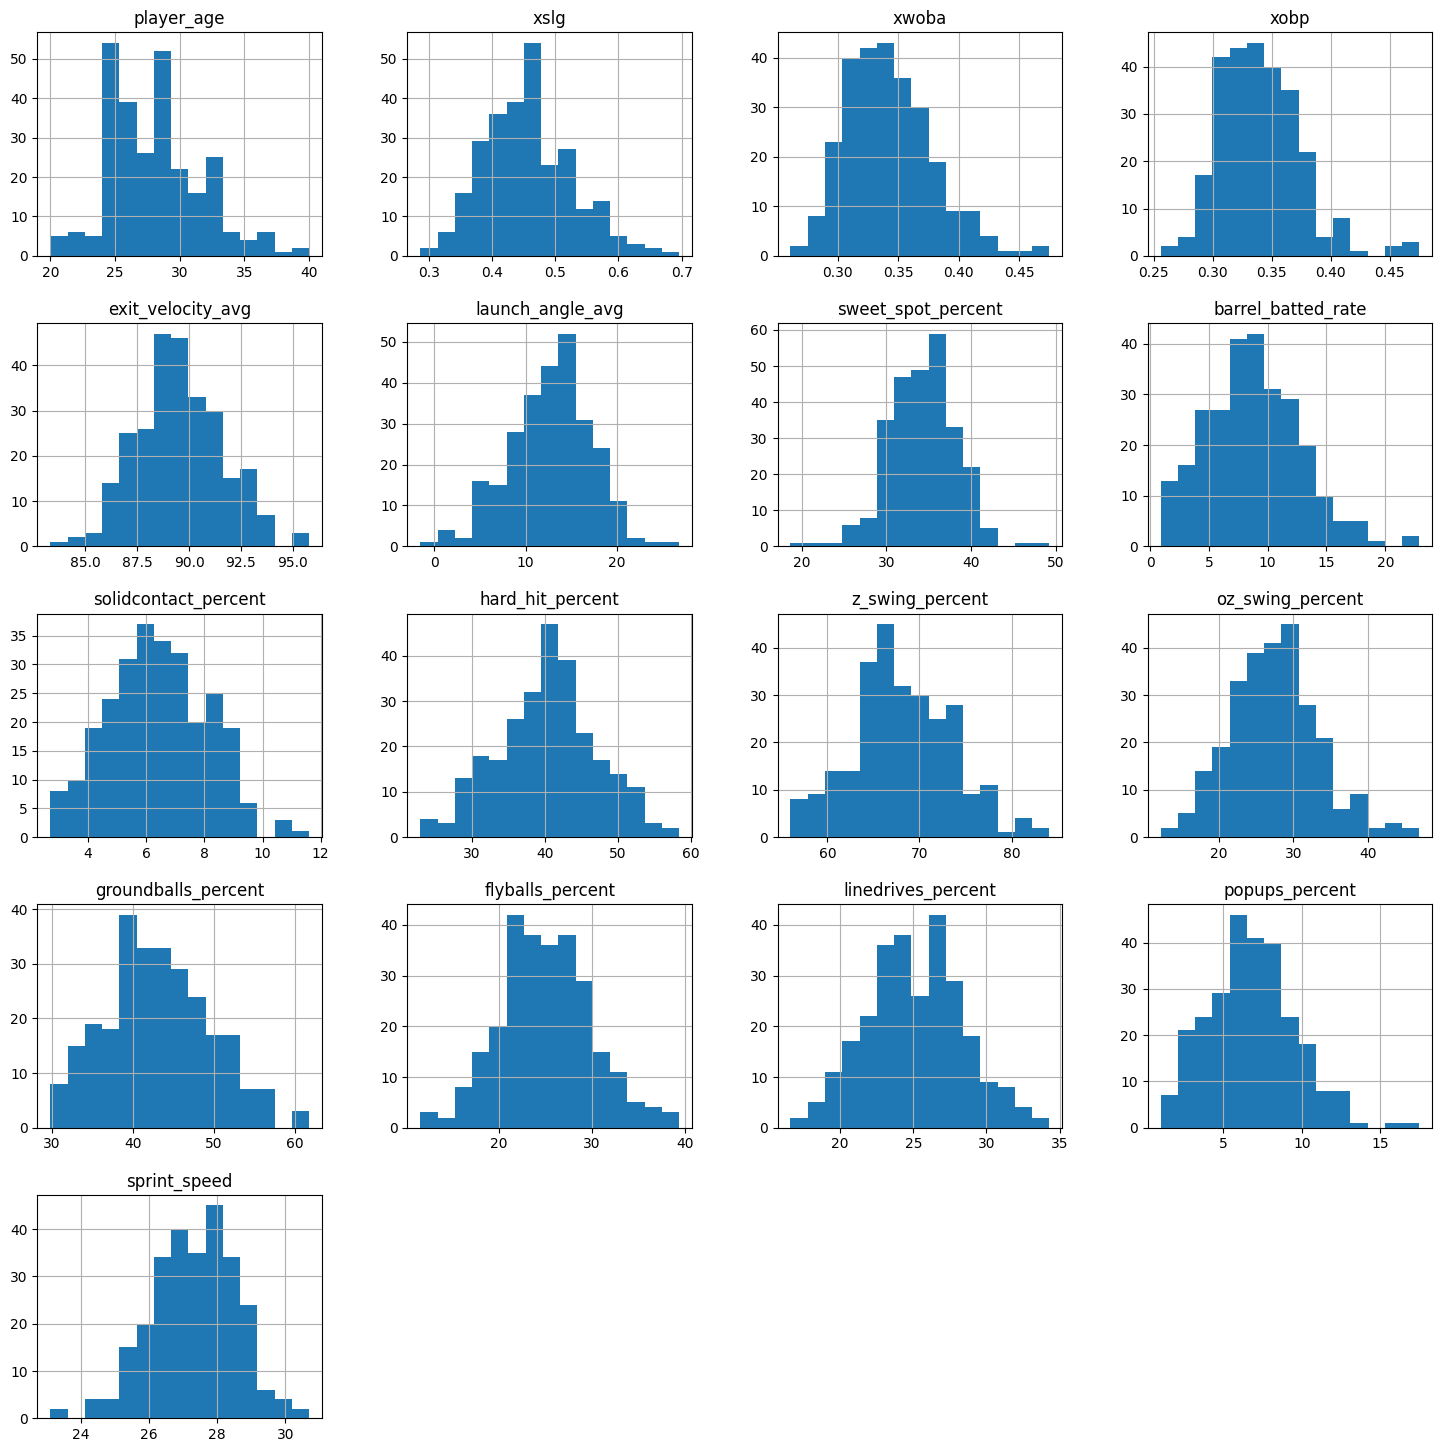

In [13]:
## Examining histograms and distributions of features
plt.rcParams.update({'font.size': 10})
X_train.hist(bins = 15, figsize = (18,18))

All features appear to have a relatively normal distribution. From this exploratory data analysis, it is apparent that all of the present features are applicable and can be used in the model. Since all features are numeric scaling will be applied throughout the dataset. 

In [14]:
## Preprocessing
colnames = list(X_train.columns)

In [15]:
## setting category names for preprocessor
scaling_feats = colnames

In [16]:
## Creating column transformer
ct = make_column_transformer(
    (StandardScaler(), scaling_feats))

ct

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['player_age', 'xslg', 'xwoba', 'xobp',
                                  'exit_velocity_avg', 'launch_angle_avg',
                                  'sweet_spot_percent', 'barrel_batted_rate',
                                  'solidcontact_percent', 'hard_hit_percent',
                                  'z_swing_percent', 'oz_swing_percent',
                                  'groundballs_percent', 'flyballs_percent',
                                  'linedrives_percent', 'popups_percent',
                                  'sprint_speed'])])

In [17]:
# Fitting X_train with scaled values, transforming both X_train and X_test
transformed_X_train = ct.fit_transform(X_train)
transformed_X_test = ct.transform(X_test)

In [18]:
## Creating transformed data frames
X_train_transformed = pd.DataFrame(transformed_X_train, columns = colnames)
X_test_transformed = pd.DataFrame(transformed_X_test, columns = colnames)
X_train_transformed.head()

,player_age,xslg,xwoba,xobp,exit_velocity_avg,launch_angle_avg,sweet_spot_percent,barrel_batted_rate,solidcontact_percent,hard_hit_percent,z_swing_percent,oz_swing_percent,groundballs_percent,flyballs_percent,linedrives_percent,popups_percent,sprint_speed
0,-0.556902,-1.093731,-1.099798,-0.947803,-1.416081,0.768451,1.192332,-1.510456,-0.762974,-1.047023,-0.694309,-0.729839,-0.908097,0.542734,0.610144,0.397982,0.403837
1,0.010547,-0.105998,0.248914,0.579249,-1.127063,-0.598550,-0.071707,-0.720659,-0.704980,-0.972854,-0.030175,0.460638,0.782950,-0.521753,0.121666,-1.043864,0.646320
2,-0.273177,-1.442343,-1.240289,-0.654139,-0.645366,-0.985867,1.622105,-1.000909,-1.052943,-1.373366,-0.971032,-1.069975,1.017818,-0.843108,0.762793,-1.728741,0.242182
3,0.861721,-0.062422,0.389405,0.726081,0.318027,-0.735250,1.015366,-1.332115,-0.241030,-0.290500,-0.546724,-0.644805,0.485451,-1.405479,1.831338,-0.791541,-1.051058
4,-0.556902,-1.907158,-1.633664,-1.035902,-2.042286,-2.489569,-1.411588,-1.714275,-2.154825,-1.536538,0.578614,0.545672,2.019920,-1.546072,-0.336283,-1.476418,0.727147


## Testing with DummyRegressor


In [19]:
## Creating function that returns mean and sd of cv scores
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [20]:
## Performing regression with dummy regressor
s = "neg_mean_absolute_percentage_error"
results = {}
dc = DummyRegressor(strategy = "mean")
pipe = make_pipeline(ct, dc)
dc.fit(X_train, y_train)
results["dummy"] = mean_std_cross_val_scores(pipe, X_train, y_train, return_train_score = True, 
                                             scoring=s)
pd.DataFrame(results)

,dummy
fit_time,0.003 (+/- 0.001)
score_time,0.001 (+/- 0.000)
test_score,-0.222 (+/- 0.036)
train_score,-0.222 (+/- 0.009)


Results from DummyRegressor perform surprisingly well with a MAPE of 0.222 for the test set. 

## Ridge Regression

In [21]:
pipe_linear_test = make_pipeline(ct, Ridge())

In [22]:
## Performing hyperparameter optimization for alpha in ridge
param_grid_linear = {"ridge__alpha" : [0.001,0.01,0.1,1,10,100,1000]}
random_search_linear = RandomizedSearchCV(pipe_linear_test, param_grid_linear, n_iter = 100, cv = 5, n_jobs = -1,random_state = 123,
                                  scoring=s)
random_search_linear.fit(X_train, y_train)
results_lin = pd.DataFrame(random_search_linear.cv_results_).set_index("rank_test_score").sort_index()
results_lin.T


/Applications/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 7 is smaller than n_iter=100. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


rank_test_score,1,2,3,4,5,6,7
mean_fit_time,0.006533,0.006868,0.005561,0.004205,0.006073,0.010353,0.004226
std_fit_time,0.002806,0.003107,0.003555,0.002159,0.003538,0.004125,0.002085
mean_score_time,0.002368,0.002178,0.002198,0.00155,0.001781,0.002781,0.0017
std_score_time,0.001228,0.000511,0.001523,0.000087,0.000298,0.001441,0.000223
param_ridge__alpha,10,100,1,0.1,0.01,0.001,1000
params,{'ridge__alpha': 10},{'ridge__alpha': 100},{'ridge__alpha': 1},{'ridge__alpha': 0.1},{'ridge__alpha': 0.01},{'ridge__alpha': 0.001},{'ridge__alpha': 1000}
split0_test_score,-0.199085,-0.201268,-0.198577,-0.198692,-0.198544,-0.198351,-0.206654
split1_test_score,-0.182994,-0.192778,-0.180312,-0.179584,-0.179289,-0.179099,-0.215095
split2_test_score,-0.217001,-0.203723,-0.23266,-0.234702,-0.235157,-0.235538,-0.197487
split3_test_score,-0.152178,-0.160045,-0.152991,-0.153166,-0.153405,-0.153681,-0.17204


In [23]:
## Applying ridge model with alpha = 10
pipe_linear = make_pipeline(ct, Ridge(alpha = 10))
results["linear"] = mean_std_cross_val_scores(pipe_linear, X_train, y_train, return_train_score = True, scoring = "neg_mean_absolute_percentage_error")
pd.DataFrame(results)

,dummy,linear
fit_time,0.003 (+/- 0.001),0.003 (+/- 0.000)
score_time,0.001 (+/- 0.000),0.002 (+/- 0.001)
test_score,-0.222 (+/- 0.036),-0.198 (+/- 0.034)
train_score,-0.222 (+/- 0.009),-0.186 (+/- 0.008)


Ridge performs slightly better than the DummyRegressor with a MAPE of 0.198 for the test set. 

## Gradient Boosted Models

In [24]:
## Creating pipelines for the three models
pipe_rf = make_pipeline(ct, RandomForestRegressor(random_state = 123, n_jobs = -1))
pipe_xg = make_pipeline(ct, XGBRegressor(random_state = 123, eval_metric = "logloss", verbosity = 0))
pipe_cat = make_pipeline(ct, CatBoostRegressor(verbose=0, random_state=123))


In [25]:
## Hyperparameter optimization for random forest regressor
param_grid_rf = {"randomforestregressor__max_depth" : [2,4,6,8,10,12,14,16,18,20],
               "randomforestregressor__n_estimators" : [2,4,6,8,10,12,14,16,18,20]}
random_search_rf = RandomizedSearchCV(pipe_rf, param_grid_rf, n_iter = 100, cv = 5, n_jobs = -1,random_state = 123,
                                  scoring = s)
random_search_rf.fit(X_train, y_train)
results_rf = pd.DataFrame(random_search_rf.cv_results_).set_index("rank_test_score").sort_index()
results_rf.T

rank_test_score,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
mean_fit_time,0.034781,0.03694,0.039916,0.028628,0.028347,0.02993,0.037342,0.039887,0.043431,0.025658,...,0.027516,0.02967,0.020516,0.017407,0.022056,0.021872,0.016935,0.02009,0.021417,0.019825
std_fit_time,0.001538,0.0072,0.001936,0.001254,0.004347,0.001366,0.002751,0.007219,0.021672,0.002932,...,0.010806,0.009336,0.008517,0.006207,0.006296,0.0084,0.001385,0.005427,0.006126,0.003757
mean_score_time,0.010489,0.011623,0.010953,0.009706,0.009643,0.012398,0.010763,0.011129,0.018368,0.011906,...,0.011142,0.014786,0.008745,0.009051,0.010165,0.009,0.009146,0.007691,0.010177,0.008966
std_score_time,0.001422,0.003774,0.001504,0.00153,0.001555,0.003013,0.001256,0.001603,0.013492,0.001928,...,0.004172,0.00769,0.004619,0.004238,0.002026,0.002621,0.005232,0.00203,0.00244,0.003011
param_randomforestregressor__n_estimators,16,14,20,10,8,14,18,16,12,8,...,4,4,2,2,2,2,2,2,2,2
param_randomforestregressor__max_depth,2,4,2,4,4,2,2,4,2,2,...,14,20,6,8,10,12,16,14,20,18
params,"{'randomforestregressor__n_estimators': 16, 'r...","{'randomforestregressor__n_estimators': 14, 'r...","{'randomforestregressor__n_estimators': 20, 'r...","{'randomforestregressor__n_estimators': 10, 'r...","{'randomforestregressor__n_estimators': 8, 'ra...","{'randomforestregressor__n_estimators': 14, 'r...","{'randomforestregressor__n_estimators': 18, 'r...","{'randomforestregressor__n_estimators': 16, 'r...","{'randomforestregressor__n_estimators': 12, 'r...","{'randomforestregressor__n_estimators': 8, 'ra...",...,"{'randomforestregressor__n_estimators': 4, 'ra...","{'randomforestregressor__n_estimators': 4, 'ra...","{'randomforestregressor__n_estimators': 2, 'ra...","{'randomforestregressor__n_estimators': 2, 'ra...","{'randomforestregressor__n_estimators': 2, 'ra...","{'randomforestregressor__n_estimators': 2, 'ra...","{'randomforestregressor__n_estimators': 2, 'ra...","{'randomforestregressor__n_estimators': 2, 'ra...","{'randomforestregressor__n_estimators': 2, 'ra...","{'randomforestregressor__n_estimators': 2, 'ra..."
split0_test_score,-0.204814,-0.211645,-0.2068,-0.208601,-0.210578,-0.206923,-0.207042,-0.212154,-0.20579,-0.203212,...,-0.270507,-0.255904,-0.237167,-0.245897,-0.259016,-0.265277,-0.264352,-0.271674,-0.265043,-0.269241
split1_test_score,-0.212,-0.205379,-0.211547,-0.212075,-0.211663,-0.211751,-0.211695,-0.207496,-0.214069,-0.212691,...,-0.246188,-0.245473,-0.258424,-0.25004,-0.266267,-0.269771,-0.276444,-0.278326,-0.281903,-0.281903
split2_test_score,-0.197838,-0.20915,-0.196314,-0.20778,-0.205804,-0.198721,-0.197179,-0.21011,-0.197627,-0.199668,...,-0.204384,-0.213787,-0.21313,-0.216089,-0.237586,-0.226748,-0.230501,-0.230746,-0.229295,-0.229295


In [26]:
results_rf.T.iloc[6][1]

{'randomforestregressor__n_estimators': 16,
 'randomforestregressor__max_depth': 2}

Best parameters for random forest are as shown above

In [27]:
pipe_rf1 = make_pipeline(ct, RandomForestRegressor(random_state = 123, n_jobs = -1, n_estimators = 16, max_depth = 2))
results["Random Forest"] = mean_std_cross_val_scores(pipe_rf1, X_train, y_train, return_train_score = True, scoring = s)
pd.DataFrame(results)

,dummy,linear,Random Forest
fit_time,0.003 (+/- 0.001),0.003 (+/- 0.000),0.015 (+/- 0.002)
score_time,0.001 (+/- 0.000),0.002 (+/- 0.001),0.004 (+/- 0.001)
test_score,-0.222 (+/- 0.036),-0.198 (+/- 0.034),-0.206 (+/- 0.030)
train_score,-0.222 (+/- 0.009),-0.186 (+/- 0.008),-0.185 (+/- 0.005)


Random forest performs worse than Ridge with additional overfitting

In [28]:
## hyperparameter optimization for XGBoost
param_grid_xgb = {"xgbregressor__max_depth" : [2,4,6,8,10,12,14,16,18,20],
               "xgbregressor__learning_rate" : [0.001,0.01,0.1,0.2,0.3,0.4]}
random_search_xgb = RandomizedSearchCV(pipe_xg, param_grid_xgb, n_iter = 40, cv = 5, n_jobs = -1,random_state = 123,
                                  scoring = s)
random_search_xgb.fit(X_train, y_train)
results_xgb = pd.DataFrame(random_search_xgb.cv_results_).set_index("rank_test_score").sort_index()
results_xgb.T

rank_test_score,1,2,3,4,5,6,7,8,9,10,...,31,32,33,34,35,36,36,36,36,36
mean_fit_time,0.106928,0.094713,0.113819,0.035508,0.063229,0.0857,0.143643,0.148721,0.154615,0.150265,...,0.119746,0.084378,0.036704,0.062511,0.080661,0.063089,0.090056,0.087428,0.093998,0.078713
std_fit_time,0.016028,0.013339,0.030429,0.005159,0.008889,0.022992,0.01356,0.013568,0.032812,0.027804,...,0.01863,0.012916,0.009726,0.011135,0.007168,0.009768,0.020445,0.011053,0.040323,0.019549
mean_score_time,0.004387,0.002351,0.002323,0.002407,0.003355,0.004365,0.005397,0.003529,0.00337,0.002626,...,0.004356,0.002221,0.004074,0.002602,0.003335,0.002624,0.003209,0.00374,0.002588,0.002959
std_score_time,0.001919,0.000056,0.000042,0.000716,0.002281,0.00165,0.004055,0.001188,0.000955,0.00008,...,0.003762,0.000048,0.00235,0.000479,0.001547,0.000822,0.002105,0.00189,0.000575,0.001457
param_xgbregressor__max_depth,20,12,16,2,4,18,20,10,16,14,...,18,14,2,4,8,16,10,12,14,18
param_xgbregressor__learning_rate,0.2,0.2,0.2,0.1,0.1,0.3,0.1,0.1,0.1,0.1,...,0.01,0.01,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
params,"{'xgbregressor__max_depth': 20, 'xgbregressor_...","{'xgbregressor__max_depth': 12, 'xgbregressor_...","{'xgbregressor__max_depth': 16, 'xgbregressor_...","{'xgbregressor__max_depth': 2, 'xgbregressor__...","{'xgbregressor__max_depth': 4, 'xgbregressor__...","{'xgbregressor__max_depth': 18, 'xgbregressor_...","{'xgbregressor__max_depth': 20, 'xgbregressor_...","{'xgbregressor__max_depth': 10, 'xgbregressor_...","{'xgbregressor__max_depth': 16, 'xgbregressor_...","{'xgbregressor__max_depth': 14, 'xgbregressor_...",...,"{'xgbregressor__max_depth': 18, 'xgbregressor_...","{'xgbregressor__max_depth': 14, 'xgbregressor_...","{'xgbregressor__max_depth': 2, 'xgbregressor__...","{'xgbregressor__max_depth': 4, 'xgbregressor__...","{'xgbregressor__max_depth': 8, 'xgbregressor__...","{'xgbregressor__max_depth': 16, 'xgbregressor_...","{'xgbregressor__max_depth': 10, 'xgbregressor_...","{'xgbregressor__max_depth': 12, 'xgbregressor_...","{'xgbregressor__max_depth': 14, 'xgbregressor_...","{'xgbregressor__max_depth': 18, 'xgbregressor_..."
split0_test_score,-0.22653,-0.22224,-0.237987,-0.230747,-0.237101,-0.220321,-0.239166,-0.249804,-0.239166,-0.2429,...,-0.279598,-0.279183,-0.691471,-0.69181,-0.691642,-0.691642,-0.691642,-0.691642,-0.691642,-0.691642
split1_test_score,-0.186336,-0.193074,-0.186718,-0.215858,-0.213328,-0.203705,-0.180145,-0.187554,-0.184263,-0.186307,...,-0.295135,-0.29555,-0.700936,-0.700486,-0.701894,-0.70183,-0.70183,-0.70183,-0.70183,-0.70183
split2_test_score,-0.237583,-0.234328,-0.23663,-0.206293,-0.213314,-0.220286,-0.226181,-0.227981,-0.226233,-0.224043,...,-0.307471,-0.307762,-0.711485,-0.712212,-0.714185,-0.71426,-0.71426,-0.71426,-0.71426,-0.71426


In [29]:
results_xgb.T.iloc[6][1]

{'xgbregressor__max_depth': 20, 'xgbregressor__learning_rate': 0.2}

Best parameters for XGBoost are max_depth = 20 and learning_rate = 0.2

In [30]:
pipe_xgb = make_pipeline(ct, XGBRegressor(random_state = 123, eval_metric = "logloss", verbosity = 0
                                        , max_depth = 20, learning_rate = 0.2))
results["XGB"] = mean_std_cross_val_scores(pipe_xgb, X_train, y_train, return_train_score = True, scoring = s)
pd.DataFrame(results)

,dummy,linear,Random Forest,XGB
fit_time,0.003 (+/- 0.001),0.003 (+/- 0.000),0.015 (+/- 0.002),0.078 (+/- 0.020)
score_time,0.001 (+/- 0.000),0.002 (+/- 0.001),0.004 (+/- 0.001),0.003 (+/- 0.000)
test_score,-0.222 (+/- 0.036),-0.198 (+/- 0.034),-0.206 (+/- 0.030),-0.211 (+/- 0.040)
train_score,-0.222 (+/- 0.009),-0.186 (+/- 0.008),-0.185 (+/- 0.005),-0.000 (+/- 0.000)


XGBoost severely overfitting the training data, and performs poorly on the validation data. 

In [31]:
# Hyperparameter optimization for CatBoost
param_grid_cat = {"catboostregressor__learning_rate" : [0.001,0.01,0.1,0.2],
                  "catboostregressor__n_estimators" : [10,50,100,200,300]}
random_search_cat = RandomizedSearchCV(pipe_cat, param_grid_cat, n_iter = 20, cv = 5, n_jobs = -1, random_state = 123,
                                      scoring = s)
random_search_cat.fit(X_train, y_train)
results_cat = pd.DataFrame(random_search_cat.cv_results_).set_index("rank_test_score").sort_index()
results_cat.T

rank_test_score,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
mean_fit_time,0.839009,0.418614,0.090211,0.022223,0.2204,0.025262,0.184216,0.093155,0.103674,0.343172,0.37018,0.653322,0.381427,0.503196,0.549391,0.413083,0.234072,0.029375,0.184608,0.131525
std_fit_time,0.323635,0.015134,0.003743,0.001565,0.01533,0.004056,0.010246,0.004655,0.00857,0.162597,0.009173,0.043385,0.013682,0.054893,0.014259,0.015692,0.015055,0.006002,0.032943,0.008091
mean_score_time,0.005967,0.003437,0.002722,0.002777,0.004067,0.003621,0.002827,0.002591,0.002796,0.006684,0.002487,0.003202,0.003096,0.002711,0.00261,0.003346,0.003508,0.003657,0.004577,0.00538
std_score_time,0.003032,0.001096,0.000478,0.000457,0.001554,0.001311,0.00048,0.00024,0.000384,0.005067,0.000118,0.000391,0.000422,0.000481,0.000229,0.001332,0.001103,0.000267,0.00112,0.001073
param_catboostregressor__n_estimators,300,200,50,10,100,10,100,50,50,100,200,300,200,300,300,200,100,10,50,10
param_catboostregressor__learning_rate,0.01,0.01,0.1,0.2,0.01,0.1,0.1,0.2,0.01,0.2,0.1,0.001,0.2,0.2,0.1,0.001,0.001,0.01,0.001,0.001
params,"{'catboostregressor__n_estimators': 300, 'catb...","{'catboostregressor__n_estimators': 200, 'catb...","{'catboostregressor__n_estimators': 50, 'catbo...","{'catboostregressor__n_estimators': 10, 'catbo...","{'catboostregressor__n_estimators': 100, 'catb...","{'catboostregressor__n_estimators': 10, 'catbo...","{'catboostregressor__n_estimators': 100, 'catb...","{'catboostregressor__n_estimators': 50, 'catbo...","{'catboostregressor__n_estimators': 50, 'catbo...","{'catboostregressor__n_estimators': 100, 'catb...","{'catboostregressor__n_estimators': 200, 'catb...","{'catboostregressor__n_estimators': 300, 'catb...","{'catboostregressor__n_estimators': 200, 'catb...","{'catboostregressor__n_estimators': 300, 'catb...","{'catboostregressor__n_estimators': 300, 'catb...","{'catboostregressor__n_estimators': 200, 'catb...","{'catboostregressor__n_estimators': 100, 'catb...","{'catboostregressor__n_estimators': 10, 'catbo...","{'catboostregressor__n_estimators': 50, 'catbo...","{'catboostregressor__n_estimators': 10, 'catbo..."
split0_test_score,-0.203738,-0.201975,-0.211627,-0.206934,-0.206793,-0.208829,-0.22224,-0.217075,-0.215362,-0.220525,-0.228998,-0.219884,-0.225036,-0.225141,-0.229153,-0.221892,-0.224042,-0.224178,-0.225363,-0.22634
split1_test_score,-0.214759,-0.217087,-0.222325,-0.21881,-0.223426,-0.225107,-0.213265,-0.222707,-0.228019,-0.22632,-0.216768,-0.22996,-0.230423,-0.230475,-0.221104,-0.231286,-0.23287,-0.233119,-0.233739,-0.234453
split2_test_score,-0.194454,-0.194255,-0.199499,-0.198393,-0.192945,-0.195358,-0.205622,-0.191293,-0.193386,-0.191757,-0.206334,-0.192846,-0.191012,-0.19117,-0.2066,-0.192714,-0.192688,-0.192781,-0.192756,-0.19283


In [32]:
results_cat.T.iloc[6][1]

{'catboostregressor__n_estimators': 300,
 'catboostregressor__learning_rate': 0.01}

Best parameters for catboost are n_estimators = 300 and learning_rate = 0.01

In [33]:
pipe_catb = make_pipeline(ct, CatBoostRegressor(verbose=0, random_state=123, n_estimators = 300, learning_rate = 0.01))
results["CatBoost"] = mean_std_cross_val_scores(pipe_catb, X_train, y_train, return_train_score = True, scoring = s)
pd.DataFrame(results)   

,dummy,linear,Random Forest,XGB,CatBoost
fit_time,0.003 (+/- 0.001),0.003 (+/- 0.000),0.015 (+/- 0.002),0.078 (+/- 0.020),0.221 (+/- 0.013)
score_time,0.001 (+/- 0.000),0.002 (+/- 0.001),0.004 (+/- 0.001),0.003 (+/- 0.000),0.003 (+/- 0.001)
test_score,-0.222 (+/- 0.036),-0.198 (+/- 0.034),-0.206 (+/- 0.030),-0.211 (+/- 0.040),-0.205 (+/- 0.031)
train_score,-0.222 (+/- 0.009),-0.186 (+/- 0.008),-0.185 (+/- 0.005),-0.000 (+/- 0.000),-0.152 (+/- 0.004)


CatBoost provides mildly better than the other gradient boosted trees, however Ridge is still the most effective model at the moment. 

## Feature Selection

In [34]:
## performing forward selection with Ridge to see if model accuracy can be improved
pipe_forward_ridge = make_pipeline(
    ct,
    SequentialFeatureSelector(Ridge(alpha = 10), 
                              direction="forward", 
                              n_features_to_select='auto', 
                              tol=None),
    Ridge(alpha = 10),
)

In [35]:
results["ridgeselected"] = mean_std_cross_val_scores(pipe_forward_ridge, X_train, y_train, return_train_score = True,
                                                    scoring = s)
pd.DataFrame(results)

,dummy,linear,Random Forest,XGB,CatBoost,ridgeselected
fit_time,0.003 (+/- 0.001),0.003 (+/- 0.000),0.015 (+/- 0.002),0.078 (+/- 0.020),0.221 (+/- 0.013),0.425 (+/- 0.025)
score_time,0.001 (+/- 0.000),0.002 (+/- 0.001),0.004 (+/- 0.001),0.003 (+/- 0.000),0.003 (+/- 0.001),0.001 (+/- 0.000)
test_score,-0.222 (+/- 0.036),-0.198 (+/- 0.034),-0.206 (+/- 0.030),-0.211 (+/- 0.040),-0.205 (+/- 0.031),-0.203 (+/- 0.034)
train_score,-0.222 (+/- 0.009),-0.186 (+/- 0.008),-0.185 (+/- 0.005),-0.000 (+/- 0.000),-0.152 (+/- 0.004),-0.187 (+/- 0.008)


It appears that the most effective model will use Ridge with the entire feature set. 

## Feature importances

In [36]:
pipe_opt = make_pipeline(ct, Ridge(alpha = 10))

In [37]:
pipe_opt.fit(X_train, y_train)
coeffs = pipe_opt.named_steps["ridge"].coef_
coeffs

array([-0.05054623,  0.14957811,  0.19416585,  0.04533842,  0.08543072,
       -0.07848659, -0.06183754, -0.22123497,  0.02589888, -0.00261416,
       -0.05518282,  0.02187534, -0.07070822,  0.06256229, -0.00994107,
        0.06248249,  0.07850999])

In [38]:
pd.DataFrame(data=coeffs, index=X_train_transformed.columns, columns=["Coefficients"]).sort_values(by = "Coefficients")

,Coefficients
barrel_batted_rate,-0.221235
launch_angle_avg,-0.078487
groundballs_percent,-0.070708
sweet_spot_percent,-0.061838
z_swing_percent,-0.055183
player_age,-0.050546
linedrives_percent,-0.009941
hard_hit_percent,-0.002614
oz_swing_percent,0.021875
solidcontact_percent,0.025899


The feature importances are generally as desired, with important expected stats such as xslg and xwoba being the features with the most positive correlation to fantasy points. Barrel rate being the most negatively correlated feature is quite surprising, as this is generally a metric that points upward in terms of production. 

In [39]:
pipe_opt.named_steps["ridge"].intercept_

2.4312137864516434

This intercept makes sense, as this value is around the average fantasy points per game. 

## Predictions on the test set

In [40]:
pipe_opt.fit(X_train, y_train)
test_predict = pipe_opt.predict(X_test)
test_score = mean_absolute_percentage_error(y_test, pipe_opt.predict(X_test))
test_score

0.1887603717246744

The model performs even more effectively on the test set, with a MAPE of 0.188. This indicates that the model is accurate enough to be put into use, although it could be more effective. Possible improvements will be touched on later. 

In [41]:
## Adding predictionns into dataset
y_test_df = pd.DataFrame(y_test)
y_test_df["pred_fpoints_g"] = test_predict.tolist()
y_test_df

,fpoints_g,pred_fpoints_g
player,,
"Muncy, Max",2.103448,2.650017
"Springer III, George",3.565574,2.467268
"Gurriel, Yuli",2.017544,2.526214
"Bradley Jr., Jackie",2.181818,2.129687
"Villar, Jonathan",1.211538,2.201396
...,...,...
"Arenado, Nolan",3.094595,2.296209
"Altuve, Jose",3.106383,2.467346
"Realmuto, J.T.",2.595745,2.575184


In [42]:
y_test_df['rank'] = y_test_df['pred_fpoints_g'].rank(ascending=False)
y_test_df.sort_values(by = "rank", ascending = True)

,fpoints_g,pred_fpoints_g,rank
player,,,
"Trout, Mike",3.528302,3.461586,1.0
"Bellinger, Cody",2.750000,3.402818,2.0
"Yelich, Christian",2.086207,3.269307,3.0
"Tatis Jr., Fernando",3.246154,3.062049,4.0
"Acuna Jr., Ronald",3.347826,2.848985,5.0
...,...,...,...
"Sanchez, Carlos",1.295302,1.984929,64.0
"Villar, Jonathan",2.469136,1.937785,65.0
"Anderson, Tim",2.544715,1.895062,66.0


## 2023 Predictions

In [48]:
newdata = pd.read_csv("data/2022metrics.csv")
newdata.head()

,player,year,player_age,xslg,xwoba,xobp,exit_velocity_avg,launch_angle_avg,sweet_spot_percent,barrel_batted_rate,solidcontact_percent,hard_hit_percent,z_swing_percent,oz_swing_percent,groundballs_percent,flyballs_percent,linedrives_percent,popups_percent,sprint_speed
0,"Pujols, Albert",2022,42,0.499,0.365,0.343,91.2,16.4,34.5,12.0,7.0,47.3,63.5,34.9,38.0,29.5,20.5,12.0,22.6
1,"Cabrera, Miguel",2022,39,0.331,0.275,0.290,89.9,5.0,35.2,4.7,3.7,38.2,71.3,31.5,52.5,19.6,25.9,2.0,23.1
2,"Molina, Yadier",2022,39,0.328,0.254,0.251,84.7,16.9,34.1,3.1,4.9,26.0,75.2,41.3,39.0,29.6,20.2,11.2,21.8
3,"Cano, Robinson",2022,39,0.299,0.237,0.239,88.2,5.8,29.3,4.0,4.0,41.3,77.3,40.0,54.7,18.7,20.0,6.7,24.3
4,"Suzuki, Kurt",2022,38,0.281,0.255,0.276,85.2,24.1,31.0,3.5,7.1,26.5,68.1,27.4,30.1,30.1,21.2,18.6,24.2


In [49]:
preds = pipe_opt.predict(newdata)

In [50]:
## Viewing the base predictions
newdata["prediction"] = preds.tolist()
newdata['rank'] = newdata['prediction'].rank(ascending = False)
newsorted = newdata.sort_values(by = "rank", ascending = True)
newsorted[["prediction", "rank"]].head()

,prediction,rank
417,3.158801,1.0
364,3.062389,2.0
115,3.006727,3.0
278,2.879099,4.0
222,2.874971,5.0


In [51]:
## Adding games played factor: 
gamesplayed = pd.read_csv("data/games.csv")
gamesplayed.head()

,player,G
0,"Soto, Juan",151
1,"Altuve, Jose",148
2,"Betts, Mookie",147
3,"Turner, Trea",150
4,"Freeman, Freddie",150


In [53]:
datgames = newdata.merge(gamesplayed, left_on = "player", right_on = 'player')
datgames.head()

,player,year,player_age,xslg,xwoba,xobp,exit_velocity_avg,launch_angle_avg,sweet_spot_percent,barrel_batted_rate,...,z_swing_percent,oz_swing_percent,groundballs_percent,flyballs_percent,linedrives_percent,popups_percent,sprint_speed,prediction,rank,G
0,"Cabrera, Miguel",2022,39,0.331,0.275,0.290,89.9,5.0,35.2,4.7,...,71.3,31.5,52.5,19.6,25.9,2.0,23.1,1.321892,455.0,91
1,"Cano, Robinson",2022,39,0.299,0.237,0.239,88.2,5.8,29.3,4.0,...,77.3,40.0,54.7,18.7,20.0,6.7,24.3,1.162663,463.0,26
2,"Suzuki, Kurt",2022,38,0.281,0.255,0.276,85.2,24.1,31.0,3.5,...,68.1,27.4,30.1,30.1,21.2,18.6,24.2,1.608989,422.0,18
3,"Peralta, David",2022,34,0.399,0.313,0.318,90.3,15.1,35.0,8.5,...,69.2,32.9,36.3,28.4,26.3,9.1,27.6,2.250209,125.0,86
4,"Escobar, Alcides",2022,35,0.264,0.233,0.252,81.8,15.7,39.1,1.1,...,70.8,36.6,38.0,20.7,30.4,10.9,28.2,1.249094,459.0,26


In [54]:
datgames['fpoints'] = datgames['prediction']*datgames['G']
datgames.head()

,player,year,player_age,xslg,xwoba,xobp,exit_velocity_avg,launch_angle_avg,sweet_spot_percent,barrel_batted_rate,...,oz_swing_percent,groundballs_percent,flyballs_percent,linedrives_percent,popups_percent,sprint_speed,prediction,rank,G,fpoints
0,"Cabrera, Miguel",2022,39,0.331,0.275,0.290,89.9,5.0,35.2,4.7,...,31.5,52.5,19.6,25.9,2.0,23.1,1.321892,455.0,91,120.292135
1,"Cano, Robinson",2022,39,0.299,0.237,0.239,88.2,5.8,29.3,4.0,...,40.0,54.7,18.7,20.0,6.7,24.3,1.162663,463.0,26,30.229244
2,"Suzuki, Kurt",2022,38,0.281,0.255,0.276,85.2,24.1,31.0,3.5,...,27.4,30.1,30.1,21.2,18.6,24.2,1.608989,422.0,18,28.961803
3,"Peralta, David",2022,34,0.399,0.313,0.318,90.3,15.1,35.0,8.5,...,32.9,36.3,28.4,26.3,9.1,27.6,2.250209,125.0,86,193.517949
4,"Escobar, Alcides",2022,35,0.264,0.233,0.252,81.8,15.7,39.1,1.1,...,36.6,38.0,20.7,30.4,10.9,28.2,1.249094,459.0,26,32.476448


In [55]:
## Adding in team factor
teamfac = pd.read_csv("data/teamfactor.csv")
teamfac.head()

,Team,avg,standardized
0,ARI,0.754067,0.949181
1,ATL,0.855278,1.052617
2,BAL,0.731759,0.926382
3,BOS,0.809565,1.005899
4,CHC,0.718218,0.912543


In [57]:
teams = pd.read_csv("data/playertm.csv")
teams.head()

,player,Team
0,"Soto, Juan",SD
1,"Altuve, Jose",HOU
2,"Betts, Mookie",LAD
3,"Turner, Trea",PHI
4,"Freeman, Freddie",LAD


In [58]:
datteams = datgames.merge(teams, left_on = 'player', right_on = "player")
datteams.head()

,player,year,player_age,xslg,xwoba,xobp,exit_velocity_avg,launch_angle_avg,sweet_spot_percent,barrel_batted_rate,...,groundballs_percent,flyballs_percent,linedrives_percent,popups_percent,sprint_speed,prediction,rank,G,fpoints,Team
0,"Cabrera, Miguel",2022,39,0.331,0.275,0.290,89.9,5.0,35.2,4.7,...,52.5,19.6,25.9,2.0,23.1,1.321892,455.0,91,120.292135,DET
1,"Cano, Robinson",2022,39,0.299,0.237,0.239,88.2,5.8,29.3,4.0,...,54.7,18.7,20.0,6.7,24.3,1.162663,463.0,26,30.229244,FA
2,"Suzuki, Kurt",2022,38,0.281,0.255,0.276,85.2,24.1,31.0,3.5,...,30.1,30.1,21.2,18.6,24.2,1.608989,422.0,18,28.961803,FA
3,"Peralta, David",2022,34,0.399,0.313,0.318,90.3,15.1,35.0,8.5,...,36.3,28.4,26.3,9.1,27.6,2.250209,125.0,86,193.517949,LAD
4,"Escobar, Alcides",2022,35,0.264,0.233,0.252,81.8,15.7,39.1,1.1,...,38.0,20.7,30.4,10.9,28.2,1.249094,459.0,26,32.476448,FA


In [61]:
alldat = datteams.merge(teamfac, left_on = "Team", right_on = "Team")
alldat.head()

,player,year,player_age,xslg,xwoba,xobp,exit_velocity_avg,launch_angle_avg,sweet_spot_percent,barrel_batted_rate,...,linedrives_percent,popups_percent,sprint_speed,prediction,rank,G,fpoints,Team,avg,standardized
0,"Cabrera, Miguel",2022,39,0.331,0.275,0.290,89.9,5.0,35.2,4.7,...,25.9,2.0,23.1,1.321892,455.0,91,120.292135,DET,0.611529,0.833508
1,"Hernandez, Cesar",2022,32,0.329,0.290,0.312,84.8,9.3,33.3,2.4,...,26.4,5.8,28.3,1.882049,340.0,58,109.158860,DET,0.611529,0.833508
2,"Schoop, Jonathan",2022,30,0.338,0.268,0.267,87.0,9.7,29.1,4.8,...,24.3,9.8,27.0,1.828519,360.0,134,245.021529,DET,0.611529,0.833508
3,"Baez, Javier",2022,29,0.378,0.285,0.272,87.9,9.6,29.7,8.0,...,20.4,6.1,27.9,1.921801,321.0,147,282.504814,DET,0.611529,0.833508
4,"Haase, Eric",2022,29,0.399,0.302,0.292,87.7,17.0,32.3,8.7,...,25.8,10.0,27.9,2.052283,228.0,87,178.548592,DET,0.611529,0.833508


In [68]:
alldat['final_pred'] = alldat['fpoints']*alldat['standardized']
rankings = alldat[['player', 'Team', 'final_pred']]
rankings['rank'] = rankings['final_pred'].rank(ascending = False)
rankings.sort_values(by = "rank", ascending = True).head(100)

/var/folders/h6/_rz_hgwd06q2j4rsml2mr9yr0000gn/T/ipykernel_88429/3434210018.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rankings['rank'] = rankings['final_pred'].rank(ascending = False)


,player,Team,final_pred,rank
64,"Alvarez, Yordan",HOU,544.594794,1.0
330,"Soto, Juan",SD,540.580615,2.0
201,"Judge, Aaron",NYY,531.674773,3.0
119,"Chapman, Matt",TOR,458.006853,4.0
121,"Guerrero Jr., Vladimir",TOR,455.037587,5.0
...,...,...,...,...
303,"Mountcastle, Ryan",BAL,312.775799,96.0
30,"Marte, Ketel",ARI,312.772485,97.0
39,"Gurriel Jr., Lourdes",ARI,311.714780,98.0
361,"Miranda, Jose",MIN,311.311023,99.0


In [69]:
rankings.to_csv("HitterRankings.csv")